##GNN and Traditional algorithms for Movielens



In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec
from concurrent.futures import ProcessPoolExecutor


In [15]:

data = pd.read_csv('movielens-20m/rating.csv')

# Group by 'userId' and sample one rating from each user
test_data = data.groupby('userId').sample(n=1, random_state=42)

# Use index to drop the sampled ratings from the original data to create the training dataset
train_data = data.drop(test_data.index)

##Visual

/tmp/ipykernel_2083/4246273398.py:24: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(sample_G, pos, edge_color=colors, edge_cmap=plt.cm.Greens, width=widths)


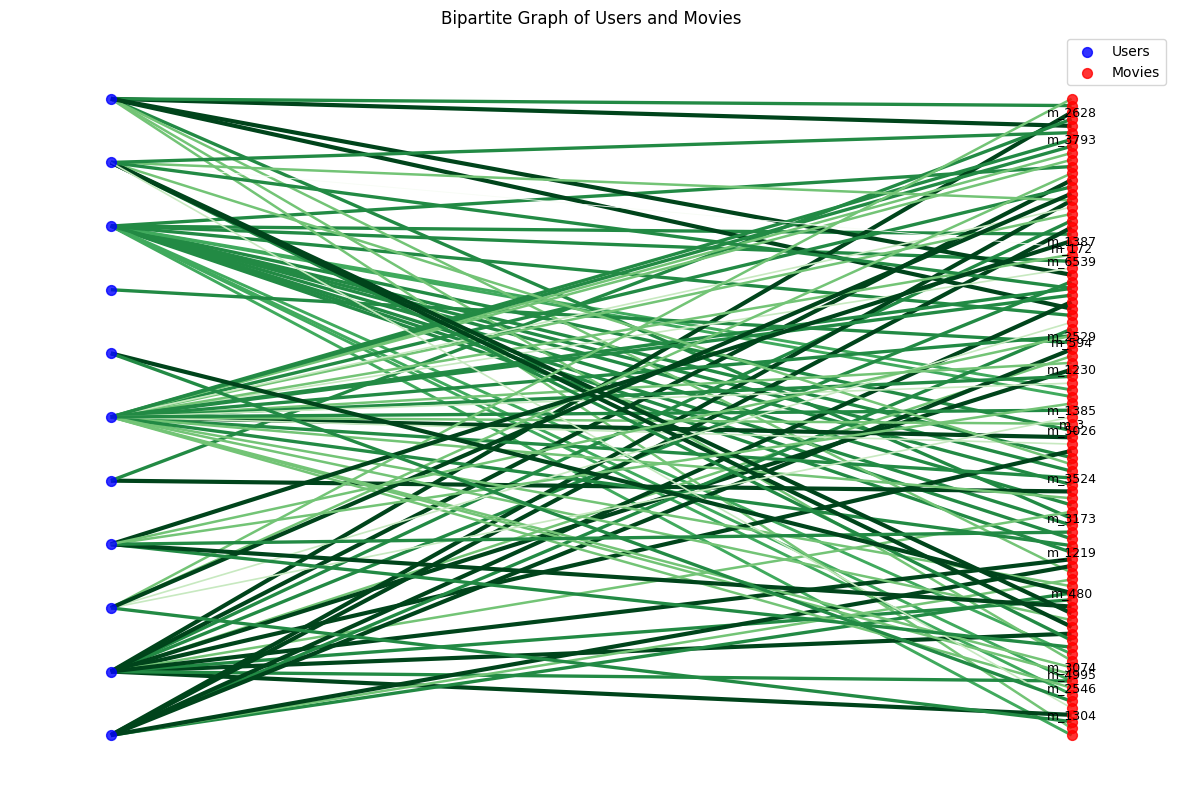

In [ ]:
sample_data = data.sample(100)
sample_G = nx.Graph()

sample_G.add_nodes_from([str(u) for u in data['userId'].unique()], bipartite=0)
sample_G.add_nodes_from(['m_' + str(m) for m in sample_data['movieId'].unique()], bipartite=1)

for _, row in sample_data.iterrows():
    sample_G.add_edge(str(row['userId']), 'm_' + str(row['movieId']), weight=row['rating'])

user_nodes = [ str(n) for n, d in sample_G.nodes(data=True) if d['bipartite']==0]
movie_nodes = [ str(n) for n, d in sample_G.nodes(data=True) if d['bipartite']==1]

pos = nx.bipartite_layout(sample_G, nodes=user_nodes)


plt.figure(figsize=(15, 10))

nx.draw_networkx_nodes(sample_G, pos, nodelist=user_nodes, node_color='blue', node_size=50, alpha=0.8, label='Users')
nx.draw_networkx_nodes(sample_G, pos, nodelist=movie_nodes, node_color='red', node_size=50, alpha=0.8, label='Movies')

edges = sample_G.edges(data=True)
colors = [d['weight'] for _, _, d in edges]
widths = [(d['weight'] * 0.6) for _, _, d in edges]
nx.draw_networkx_edges(sample_G, pos, edge_color=colors, edge_cmap=plt.cm.Greens, width=widths)

sample_movie_labels = {movie: movie for movie in np.random.choice(movie_nodes, size=20)}  # Randomly select 20 movies
nx.draw_networkx_labels(sample_G, pos, labels=sample_movie_labels, font_size=9)

plt.title("Bipartite Graph of Users and Movies")
plt.legend()
plt.axis('off')
plt.show()

In [17]:
G_train = nx.Graph()

# Add user nodes
user_nodes = train_data['userId'].astype(str).unique().tolist()
G_train.add_nodes_from(user_nodes, bipartite=0)

# Add movie nodes
movie_nodes = ['m_' + str(m) for m in train_data['movieId'].unique()]
G_train.add_nodes_from(movie_nodes, bipartite=1)

# Add edges from DataFrame
edges_df = train_data.copy()
edges_df['userId'] = edges_df['userId'].astype(str)
edges_df['movieId'] = 'm_' + edges_df['movieId'].astype(str)
nx.from_pandas_edgelist(edges_df, 'userId', 'movieId', ['rating'], create_using=G_train)

In [18]:
def predict_rating(G, user, movie):
    neighbors = list(G.neighbors(movie))
    if not neighbors:
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])

    sim_weights = []
    user_ratings = []
    for neighbor in neighbors:
        # Jaccard similarity as an example, but can be changed
        common_movies = list(nx.common_neighbors(G, user, neighbor))
        sim = len(common_movies) / (G.degree(user) + G.degree(neighbor) - len(common_movies))
        rating = G[neighbor][movie]['rating']
        
        sim_weights.append(sim)
        user_ratings.append(rating)
    
    return np.dot(user_ratings, sim_weights) / sum(sim_weights)


In [22]:
def predict_for_row(row):
    user = str(row['userId'])
    movie = 'm_' + str(row['movieId'])
    if G_train.has_node(movie):
        actual = row['rating']
        predicted = predict_rating(G_train, user, movie)
        return (actual, predicted)
    return (None, None)

with ProcessPoolExecutor(max_workers=52) as executor:
    results = list(executor.map(predict_for_row, list(test_data.itertuples(index=False))))


# Filter out None values
actual_ratings, test_predictions = zip(*[(a, p) for a, p in results if a is not None and p is not None])

# Calculate RMSE
default = np.sqrt(np.mean((3.53 - np.array(actual_ratings)) ** 2))
rmse = np.sqrt(np.mean((np.array(test_predictions) - np.array(actual_ratings)) ** 2))

In [ ]:
node2vec = Node2Vec(G_train, dimensions=64, walk_length=30, num_walks=200, workers=32)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def predict_rating_with_embeddings(G, user, movie):
    if not G.has_node(movie):
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])
    
    neighbors = list(G.neighbors(movie))
    if not neighbors:
        return np.mean([attr['rating'] for _, _, attr in G.edges(data=True) if 'rating' in attr])

    sim_weights = []
    user_ratings = []
    user_embedding = model.wv[user]
    
    for neighbor in neighbors:
        neighbor_embedding = model.wv[neighbor]
        sim = cosine_similarity(user_embedding, neighbor_embedding)
        rating = G[neighbor][movie]['rating']
        
        sim_weights.append(sim)
        user_ratings.append(rating)
    
    return np.dot(user_ratings, sim_weights) / sum(sim_weights)

test_predictions_embeddings = []
actual_ratings_embeddings = []

for _, row in test_data.iterrows():
    user = str(row['userId'])
    movie = 'm_' + str(row['movieId'])
    actual_ratings_embeddings.append(row['rating'])
    test_predictions_embeddings.append(predict_rating_with_embeddings(G_train, user, movie))

# Calculate RMSE
rmse_embeddings = np.sqrt(np.mean((np.array(test_predictions_embeddings) - np.array(actual_ratings_embeddings)) ** 2)) 

print(f"Default RMSE: {default:.2f}")
print(f"Previous RMSE: {rmse:.2f}")
print(f"Embeddings RMSE: {rmse_embeddings:.2f}")

print(test_predictions_embeddings)
print(actual_ratings_embeddings)

Computing transition probabilities:   0%|          | 0/705 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Default RMSE: 0.79
Previous RMSE: 0.91
Embeddings RMSE: 0.85
[3.7269969666329628, 4.0, 3.0, 4.776867420711847, 3.3082214156932612, 3.7269969666329628, 3.7269969666329628, 4.699812796065679, 3.7269969666329628, 4.4618106145337615, 4.0]
[3.5, 5.0, 4.0, 4.0, 3.0, 5.0, 3.0, 4.0, 4.0, 4.0, 2.5]
